> Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved BSD-3 license.<br>
> Copyright (c) 2020, Felipe N. Schuch.<br>
> [@fschuch](https://twitter.com/fschuch)

# Initialization

In [1]:
import xarray as xr
import numpy as np
from tqdm.notebook import tqdm as tqdm
import dask.array as da
import matplotlib
import matplotlib.pyplot as plt

[Dask](https://dask.org/) provides support for parallel computing and larger-than-memory arrays, both features are very useful for this application. For further information, see [Dask's Documentation](https://docs.dask.org/en/latest/).

In [2]:
import dask
from dask.distributed import Client

client = Client()

C:\Users\felip\anaconda3\lib\site-packages\distributed\node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62711 instead
  http_address["port"], self.http_server.port


In [3]:
cases = [f"{s}-{us}" for s in "1.25 2.5 5.0 10.0".split() for us in "0 15 30".split()]

# Layer-averaged quantities

The complete spatio-temporal analysis of the relevant quantities is possible in a layer averaged context per width unit, that is computed according to the equations

$$
Uh(x_1,t) = \dfrac{1}{L_3} \int_0^{L_3} \int_{x_{2r}}^{x_{2i}} u_1(x_1,x_2,x_3,t) ~ dx_2 dx_3
$$
$$
U^2h(x_1,t) = \dfrac{1}{L_3} \int_0^{L_3} \int_{x_{2r}}^{x_{2i}} \big( u_1(x_1,x_2,x_3,t) \big)^2 ~ dx_2 dx_3
$$
$$
UCh(x_1,t) = \dfrac{1}{L_3} \int_0^{L_3} \int_{x_{2r}}^{x_{2i}} u_1 (x_1,x_2,x_3,t) ~ c_t (x_1,x_2,x_3,t) ~ dx_2 dx_3
$$

For the vertical integration, $x_{2r}$ represents the bed position and $x_{2i}$ represents the interface between the underflow turbidity current and the ambient fluid, considered in this work as the position where $u_1 \times c_t = 0.005$. This step has been done in the previous example (see [00-LA-and-Convert-to-NetCDF.ipynb](00-LA-and-Convert-to-NetCDF.ipynb)), the datasets are available at [Zenodo](https://doi.org/10.5281/zenodo.4044388). After downloading them, the files for all cases can be loaded and concatenate in a single variable using:

In [4]:
paths = [f"LA-case-{case}.nc" for case in cases]

ds = (
    xr.open_mfdataset(paths, concat_dim="case", combine="nested", compat = "no_conflicts")
    .sel(t=slice(0, 4000))
    .compute()
)
ds = ds.assign_coords({"case": cases})

C:\Users\felip\anaconda3\lib\site-packages\xarray\core\alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)


And we can show in the screen all the variables in the `xarray.Dataset`:

In [5]:
ds

<xarray.Dataset>
Dimensions:  (case: 12, t: 1601, x: 801, y: 241)
Coordinates:
  * t        (t) float64 0.0 2.5 5.0 7.5 ... 3.992e+03 3.995e+03 3.998e+03 4e+03
  * y        (y) float64 0.0 0.1406 0.2812 0.4219 ... 33.33 33.47 33.61 33.75
  * x        (x) float32 0.0 0.3125 0.625 0.9375 ... 249.375 249.6875 250.0
  * case     (case) <U7 '1.25-0' '1.25-15' '1.25-30' ... '10.0-15' '10.0-30'
Data variables:
    utau     (case, t, x) float32 0.06382665 0.001508435 ... 0.011865777
    dep      (case, t, x) float32 0.0 0.0 0.0 ... 0.0022130858 0.0022131822
    uset     (case) float64 0.0 0.0015 0.003 0.0 ... 0.003 0.0 0.0015 0.003
    Ri0      (case) float64 0.2078 0.2602 0.3259 ... 0.001206 0.00151 0.001891
    Fr0      (case) float64 2.194 1.96 1.752 4.659 ... 8.905 28.8 25.74 23.0
    Re       (case) float64 2.5e+03 2.5e+03 2.5e+03 ... 2.5e+03 2.5e+03 2.5e+03
    S        (case) float64 0.0125 0.0125 0.0125 0.025 ... 0.05 0.1 0.1 0.1
    Uh       (case, t, x) float32 -0.0 -0.0 -0.0 ... 0.5849177 0.58932585
    U2h      (case, t, x) float32 -0.0 -0.0 -0.0 ... 0.10806271 0.108770296
    UCh      (case, t, x) float32 -0.0 -0.0 -0.0 ... 0.26402205 0.26640958
Attributes:
    title:    Plunging condition for particle-laden flows over sloping bottom...
    authors:  F. N. Schuch, E. Meiburg & J. H. Silvestrini
    url:      https://github.com/fschuch/incompact3d_plunging_criterion
    doi:      10.5281/zenodo.4044388
    license:  Creative Commons Attribution 4.0 International

For further information see [Why xarray](http://xarray.pydata.org/en/stable/why-xarray.html), and off course, [xarray's Documentation](http://xarray.pydata.org/en/stable/).

Now, we can compute and plot all layer-averaged quantities:

* Layer-averaged Velocity:
$$
U(x_1,t) = \dfrac{U^2h}{Uh}
$$

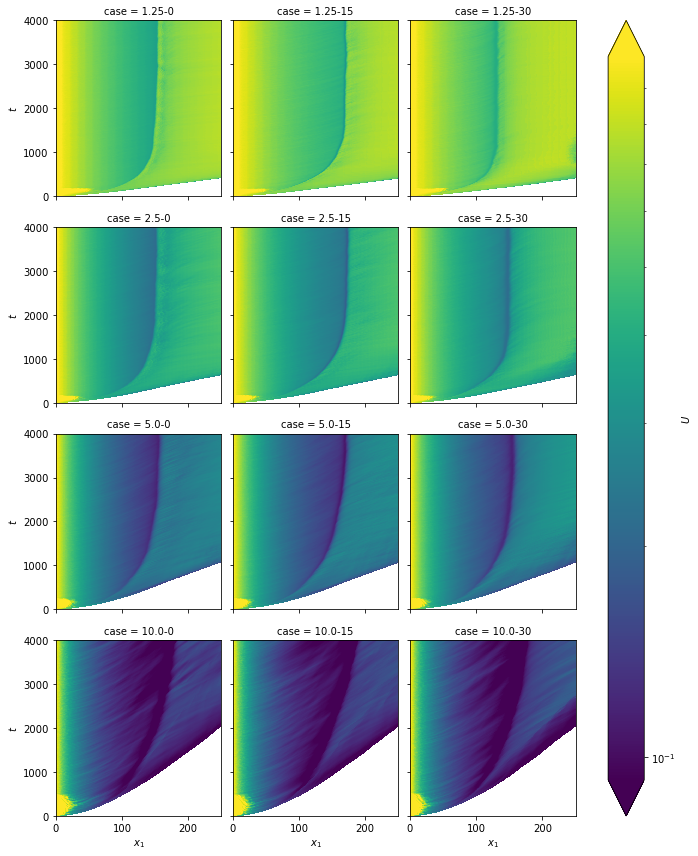

In [6]:
ds["U"] = ds.U2h / ds.Uh
ds.U.attrs = {"name": "Layer-averaged Velocity", "long_name": r"$U$"}
ds.U.plot(col="case", col_wrap=3, robust=True, norm=matplotlib.colors.LogNorm());

* Underflow depth:
$$
H(x_1,t) = \dfrac{(Uh)^2}{U^2h}
$$

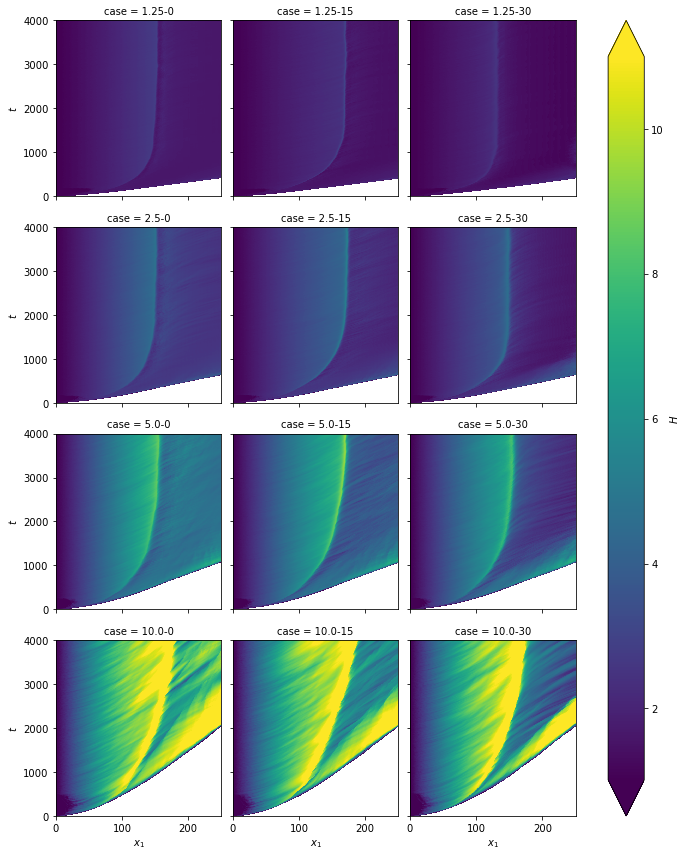

In [7]:
ds["H"] = ds.Uh ** 2.0 / ds.U2h
ds.H.attrs = {"name": "Flow depth", "long_name": r"$H$"}
ds.H.plot(col="case", col_wrap=3, robust=True);

* Mixing coefficient:
$$
\gamma(x_1,t) = \dfrac{Uh}{1} - 1
$$

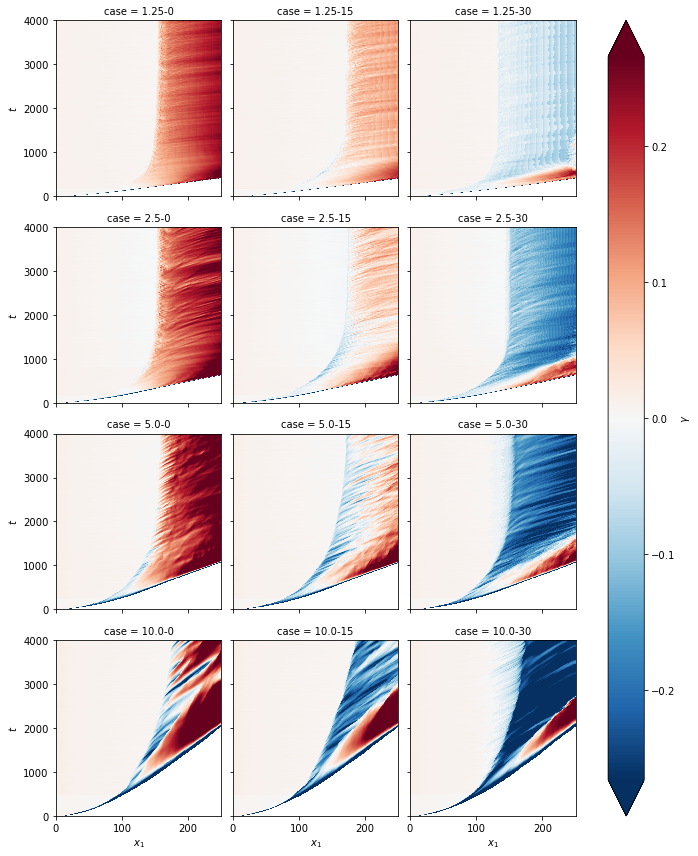

In [8]:
ds["mixing"] = ds.U * ds.H - 1.0
ds.mixing.attrs = {"name": "Mixing coefficient", "long_name": r"$\gamma$"}
ds.mixing.plot(col="case", col_wrap=3, robust=True);

* Layer-averaged total concentration:
$$
C (x_1,t) = \dfrac{UCh}{Uh}
$$

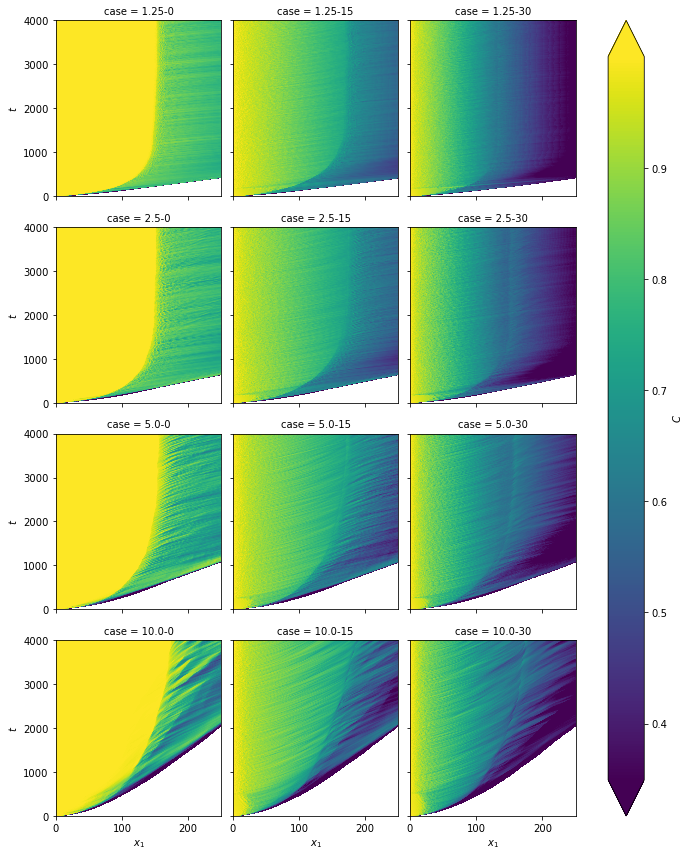

In [9]:
ds["C"] = ds.UCh / ds.Uh
ds.C.attrs = {"name": "Layer-averaged Concentration", "long_name": r"$C$"}
ds.C.plot(col="case", col_wrap=3, robust=True);

* Densimetric Froude number:
$$
Fr(x_1,t) = \dfrac{Uh}{\sqrt{CH^3}}Fr_0
$$

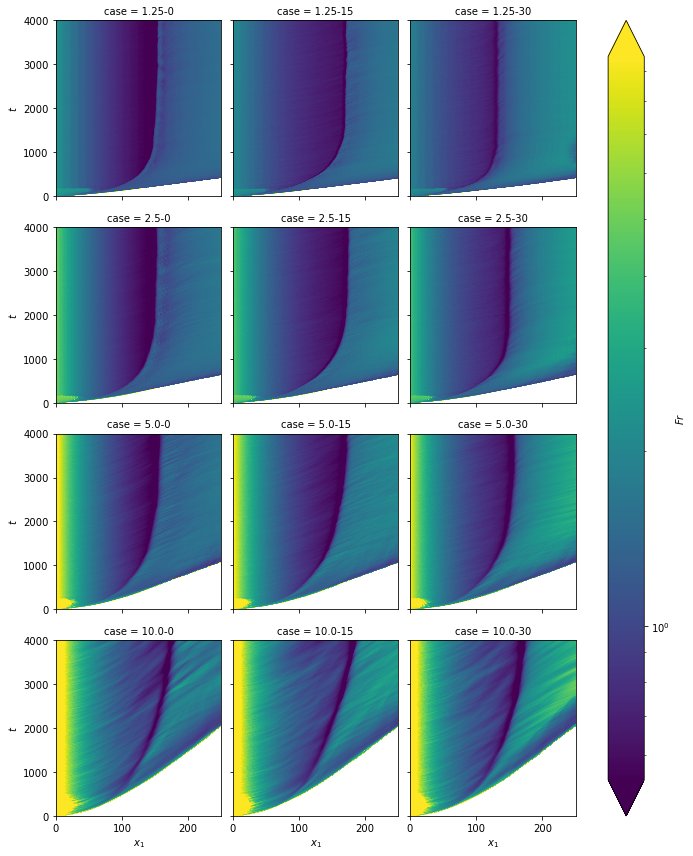

In [10]:
ds["Fr"] = ds.Fr0 * ds.Uh * (ds.C ** (-1.0 / 2.0)) * (ds.H ** (-3.0 / 2.0))
ds.Fr.attrs = {"name": "Local densimetric Fround number", "long_name": r"$Fr$"}
ds.Fr.plot(col="case", col_wrap=3, robust=True, norm=matplotlib.colors.LogNorm());

And plot the spanwise-avareged quantities:

* Bed shear velocity:

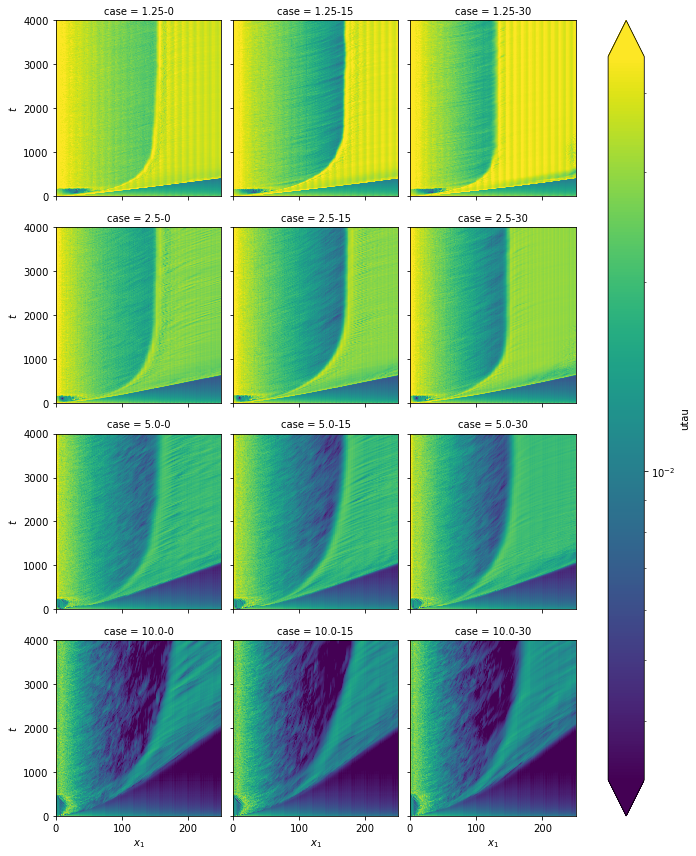

In [11]:
ds.utau.plot(col='case', col_wrap=3, robust=True, norm=matplotlib.colors.LogNorm());

* Deposition rate:

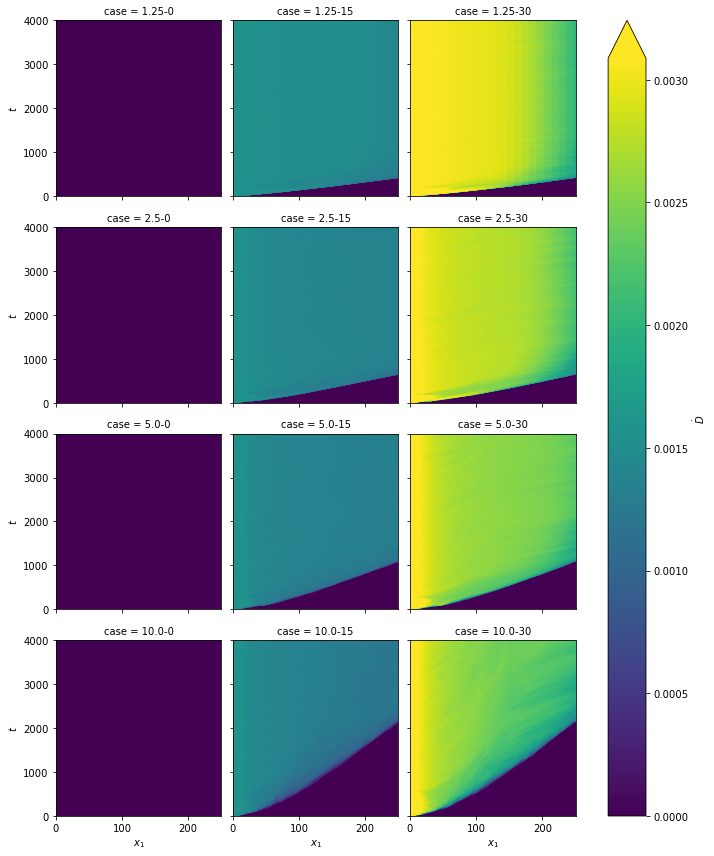

In [12]:
ds.dep.plot(col='case', col_wrap=3, robust=True);

# Other

Some of the flow features can be obtained with the layer-averaged quantities, for instance:

* The plunge point is located where the densimetric Froude number is minimum:

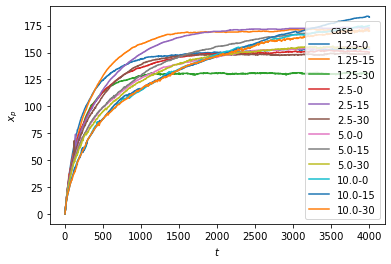

In [13]:
# Fill NaN with a large number just to avoid problems and get where it is minimum
ixp = ds.Fr.fillna(1e3).argmin(dim="x")

# Then obtain plunge point position (where it is inside the test section)
ds["xp"] = ds.x[ixp].where(ixp != ds.x.size - 1)

ds.xp.attrs = {"name": "Distance for plunging", "long_name": r"$x_p$"}
ds.xp.plot.line(x="t");

* Densimetric Frounde number at plunge point:

C:\Users\felip\anaconda3\lib\site-packages\xarray\core\nputils.py:227: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


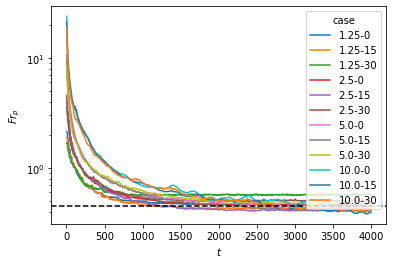

In [14]:
# It is the minimum value inside the test section
ds["Frp"] = ds.Fr.min(dim="x").where(ixp != ds.x.size - 1)

ds.Frp.attrs = {
    "name": "Densimetric Frounde number at plunge point",
    "long_name": r"$Fr_p$",
}
ds.Frp.plot.line(x="t")

plt.axhline(0.45, c="k", ls="--")

plt.yscale("log")

What is the time and case averaged densimetric Froude number at plunge point?

In [15]:
ds.Frp.sel(t=slice(4000, 6000)).mean("t").mean("case")

<xarray.DataArray 'Frp' ()>
array(0.45329615)

* Front position:

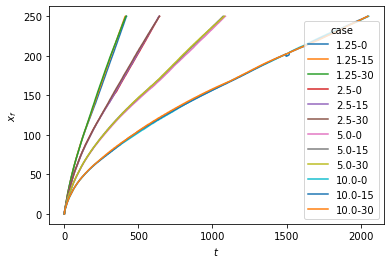

In [16]:
ixf = ds.Uh.argmin(dim="x")

ds["xf"] = ds.x[ixf].where(ds.t <= ds.t[ixf.argmax(dim="t")])
ds.xf.attrs = {"name": "Front position", "long_name": r"$x_f$"}
ds.xf.plot.line(x="t");

* Front velocity:
$$
u_f = \dfrac{d x_f}{d t}
$$

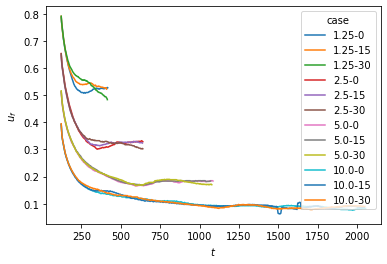

In [17]:
# a rolling average is used to reduce the noise
ds["uf"] = ds.xf.differentiate("t").rolling(t=50).mean()
ds.uf.attrs = {"name": "Front velocity", "long_name": r"$u_f$"}
ds.uf.plot.line(x="t");

# Flow evolution

Lets load the spanwise-averaged planes from case `5.0-15` as an example:

In [18]:
xyplanes = xr.load_dataset("xy-planes-case-5.0-15.nc")

In [19]:
xyplanes

<xarray.Dataset>
Dimensions:       (t: 801, x: 801, y: 121)
Coordinates:
  * x             (x) float32 0.0 0.3125 0.625 0.9375 ... 249.375 249.6875 250.0
  * y             (y) float32 16.875 16.734375 16.59375 ... 0.28125 0.140625 0.0
  * t             (t) float32 0.0 5.0 10.0 15.0 ... 3985.0 3990.0 3995.0 4000.0
Data variables:
    phi           (t, x, y) float32 0.0 0.0 0.0 ... 2.7094759e-11 1.6721305e-11
    ux            (t, x, y) float32 0.0 0.0 0.0 ... -0.040188063 -0.040198755
    uy            (t, x, y) float32 0.0 0.0 0.0 ... -2.8484597e-05 0.0
    utau          (t, x) float32 0.064214714 0.002707824 ... 0.018694893
    dep           (t, x) float32 0.0 0.0 0.0 ... 0.001327706 0.0013275965
    uset          float64 0.0015
    Ri0           float64 0.01007
    Fr0           float64 9.965
    Re            float64 2.5e+03
    S             float64 0.05
    bed_position  (x) float32 1.0 1.015625 1.03125 ... 13.46875 13.484375 13.5
Attributes:
    title:    Plunging condition for particle-laden flows over sloping bottom...
    authors:  F. N. Schuch, E. Meiburg & J. H. Silvestrini
    url:      https://github.com/fschuch/incompact3d_plunging_criterion
    doi:      10.5281/zenodo.4044388
    license:  Creative Commons Attribution 4.0 International

Now, lets select some values as time reference:

In [20]:
selected_times = [250, 500, 1000, 2000, 4000]

And plot total concentration field (notice that matplotlib can be used for adjustments):

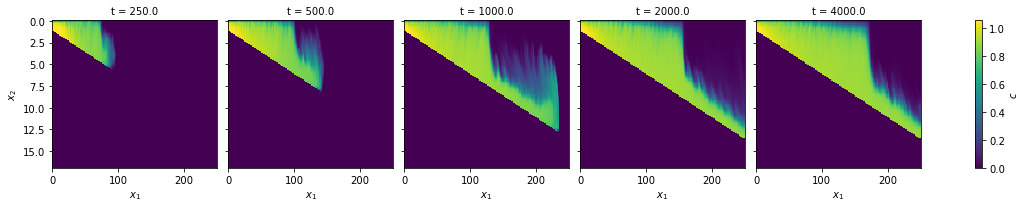

In [21]:
xyplanes.phi.sel(t=selected_times).plot(col="t", x="x")
plt.gca().invert_yaxis()
plt.show();

Now the velocity components:

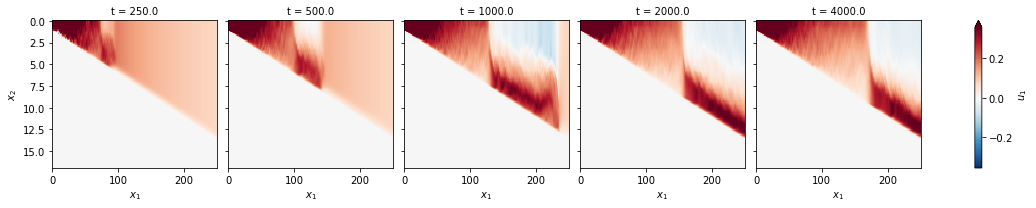

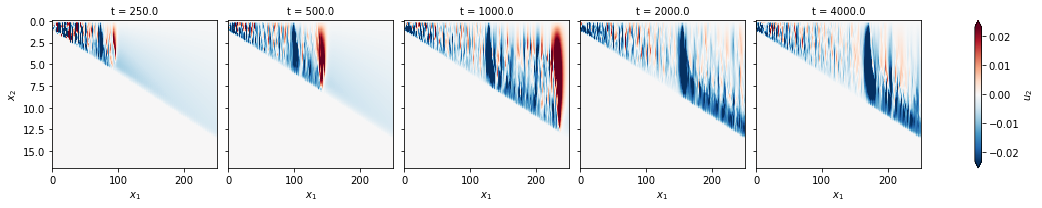

In [22]:
for var in "ux uy".split():
    xyplanes[var].sel(t=selected_times).plot(col="t", x="x", robust=True)
    plt.gca().invert_yaxis()
    plt.show();

We can extract a signal in some location:

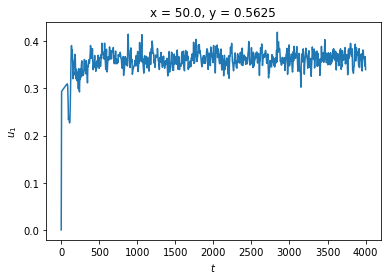

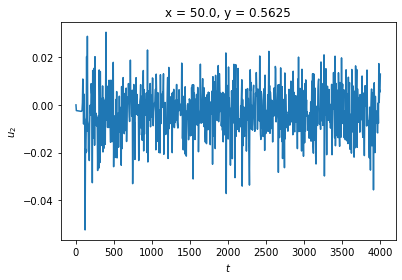

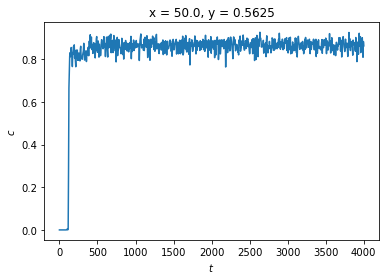

In [23]:
for var in "ux uy phi".split():
    xyplanes[var].sel(x=50.0, y=0.5, method="nearest").plot()
    plt.show();

and we can go back to `ds` and plot some variables for all cases at reference times:

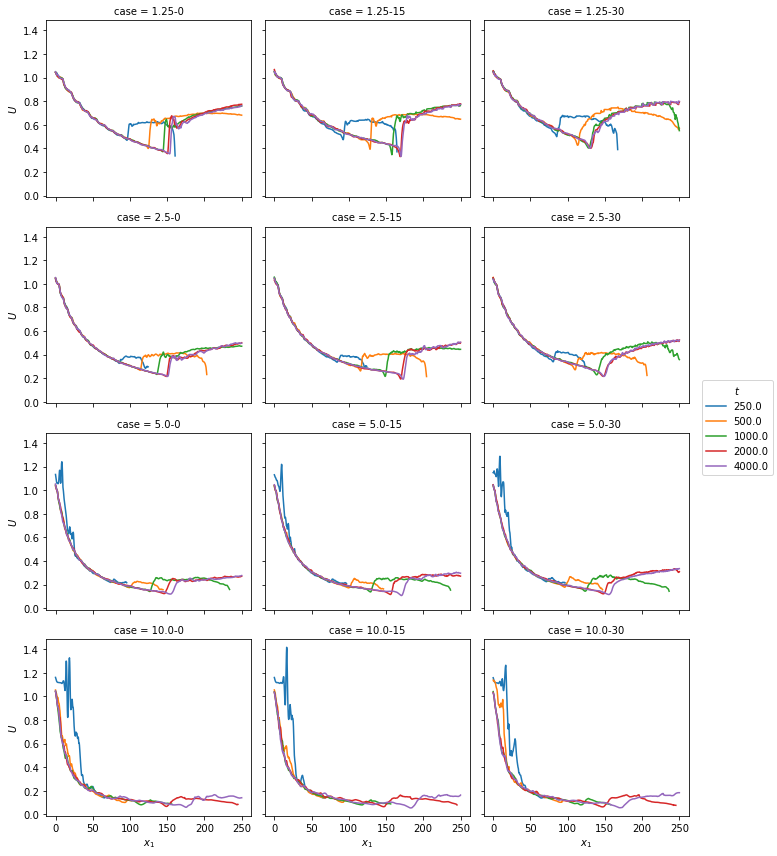

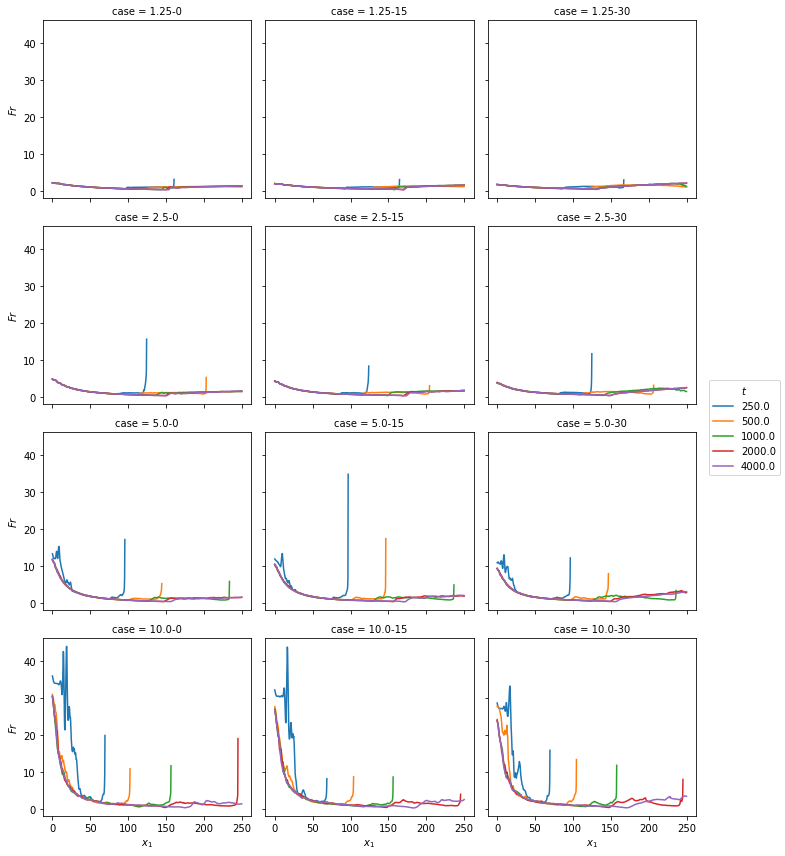

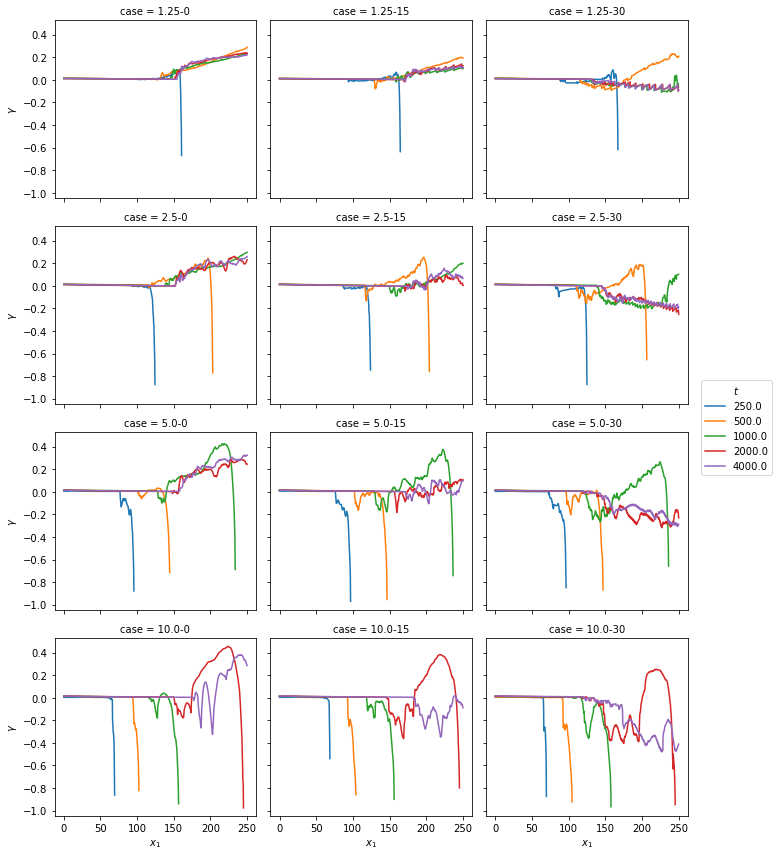

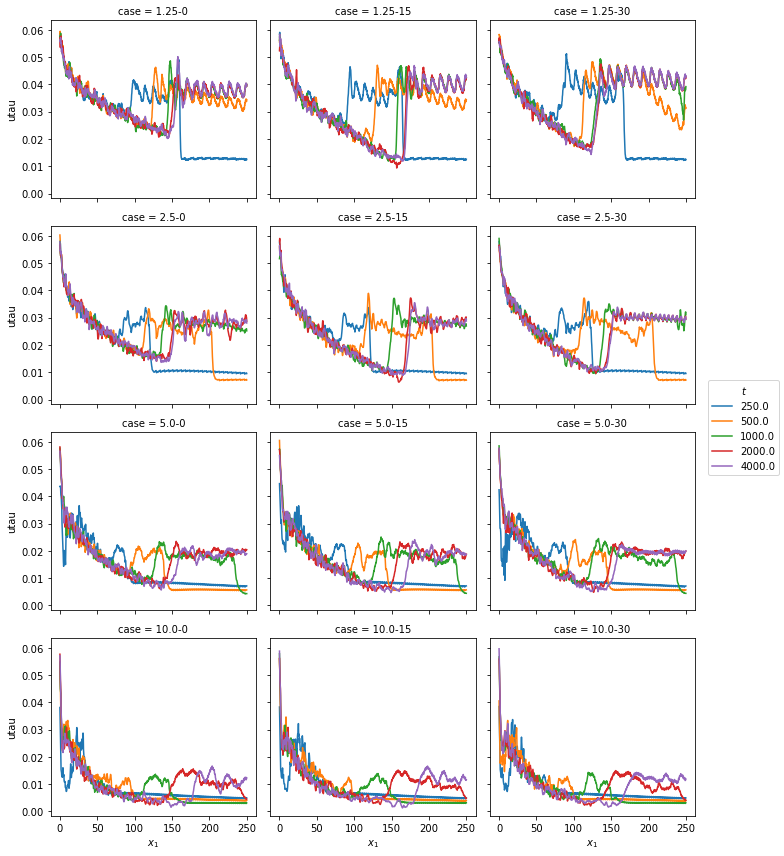

In [24]:
for var in "U Fr mixing utau".split():
    ds[var].sel(t=selected_times).plot(hue="t", x="x", col="case", col_wrap=3)
    plt.show();